* Importing Modules

In [1]:
import warnings
warnings.filterwarnings("ignore")

import spacy
import time
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

*  Load the spaCy model

In [2]:
nlp = spacy.load("en_core_web_lg")

* Load the dataset. The dataset contains two columns [Comments, Emotions]

In [3]:
df = pd.read_csv('/content/classification_data.csv', encoding='utf-8')

In [4]:
def get_word_vectors(text):
    doc = nlp(" ".join(text))
    return torch.tensor([word.vector for word in doc])

* Prepare the data

In [5]:
X = [get_word_vectors(comment.split()) for comment in df["Comment"]]
y = df["Emotion"].tolist()

* Convert labels to numerical values

In [6]:
label_to_idx = {label: idx for idx, label in enumerate(set(y))}
y = [label_to_idx[label] for label in y]

* Split the data into training and testing sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

* Pad the sequences to make the input consistent

In [8]:
def pad_sequences(sequences, max_len):
    padded_sequences = []
    for sequence in sequences:
        if len(sequence) >= max_len:
            padded_sequence = sequence[:max_len]
        else:
            padding_length = max_len - len(sequence)
            padding = torch.zeros(padding_length, sequence.shape[1], dtype=sequence.dtype)
            padded_sequence = torch.cat((sequence, padding), dim=0)
        padded_sequences.append(padded_sequence)
    return torch.stack(padded_sequences)

max_seq_len = max(seq.shape[0] for seq in X)

X_train_padded = pad_sequences(X_train, max_seq_len)
X_test_padded = pad_sequences(X_test, max_seq_len)


* Defining the LSTMClassifier class

In [9]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

* Hyperparameters of the model

In [10]:
input_dim = X_train_padded.shape[2]
hidden_dim = 128
output_dim = len(set(y_train))
num_layers = 2
dropout = 0.2
learning_rate = 0.001
batch_size = 32
num_epochs = 100

*  Initialize the model and optimizer

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMClassifier(input_dim, hidden_dim, output_dim, num_layers, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


* Convert data to PyTorch tensors

In [12]:
X_train_padded = X_train_padded.to(device)
X_test_padded = X_test_padded.to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

* Storing training and validation losses with a maximum patience of 20 epochs for early stopping

In [13]:
train_losses = []
val_losses = []

best_val_loss = float('inf')
patience = 20
wait = 0

* Model Training

In [14]:
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_padded)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    elapsed_time = time.time() - start_time

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_padded)
        loss = criterion(test_outputs, y_test)
        val_losses.append(loss.item())

        if loss < best_val_loss:
            best_val_loss = loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f'Early stopping after {epoch+1} epochs without improvement.')
                break

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Time taken : {round(elapsed_time, 2)}secs\n')

Epoch 1/100, Training Loss: 1.098818302154541, Validation Loss: 1.0995110273361206, Time taken : 38.23secs

Epoch 2/100, Training Loss: 1.09821617603302, Validation Loss: 1.100916862487793, Time taken : 74.89secs

Epoch 3/100, Training Loss: 1.098122239112854, Validation Loss: 1.101603627204895, Time taken : 108.87secs

Epoch 4/100, Training Loss: 1.098184585571289, Validation Loss: 1.1014190912246704, Time taken : 144.4secs

Epoch 5/100, Training Loss: 1.098130226135254, Validation Loss: 1.1008658409118652, Time taken : 177.81secs

Epoch 6/100, Training Loss: 1.0978224277496338, Validation Loss: 1.1002835035324097, Time taken : 212.59secs

Epoch 7/100, Training Loss: 1.0976452827453613, Validation Loss: 1.0998209714889526, Time taken : 249.68secs

Epoch 8/100, Training Loss: 1.0975162982940674, Validation Loss: 1.0995078086853027, Time taken : 298.28secs

Epoch 9/100, Training Loss: 1.0973656177520752, Validation Loss: 1.0993314981460571, Time taken : 338.49secs

Epoch 10/100, Trainin

* Plotting the training and validation loss

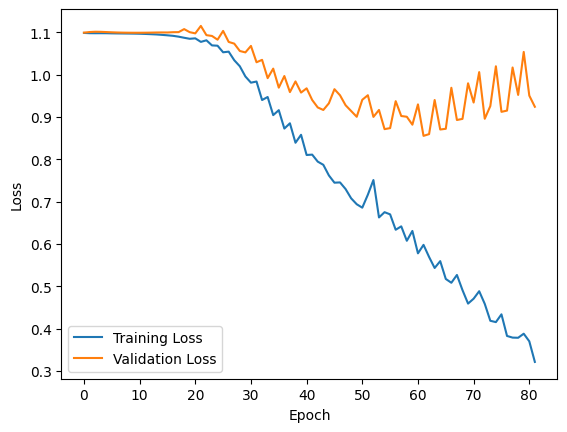

In [15]:
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

* Model evaluation

In [16]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_padded)
    _, predicted = torch.max(test_outputs, 1)

In [17]:
predicted_labels = [list(label_to_idx.keys())[list(label_to_idx.values()).index(label)] for label in predicted.tolist()]

In [18]:
y_test_labels = [list(label_to_idx.keys())[list(label_to_idx.values()).index(label)] for label in y_test.tolist()]

* The classification report

In [19]:
report = classification_report(y_test_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

       anger       0.76      0.45      0.57       392
        fear       0.52      0.78      0.63       416
         joy       0.82      0.72      0.77       380

    accuracy                           0.65      1188
   macro avg       0.70      0.65      0.65      1188
weighted avg       0.70      0.65      0.65      1188

